# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary

In [220]:
col_names = ['variance', 'skewness', 'curtosis', 'entropy', 'authentic']
data = pd.read_csv("bankAuth.txt", names=col_names)

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

NODE

In [221]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [222]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]  #X takes all column except last and Y takes last column
        num_samples, num_features = np.shape(X)

        # split until stopping conditions are met
        if curr_depth>self.max_depth:
          # do nothing
          tmp=num_samples
        else:
            # best split contains best split point of particular feature
            best_split = self.get_best_split(dataset, num_samples, num_features) 
            # check if information gain is positive

            if best_split["info_gain"]<=0:
              tmp2=best_split["info_gain"]
              #do nothing
            else:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def calculate_leaf_value(self, Y):
        ''' compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
      
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_threshold = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_threshold:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)<=0 or len(dataset_right)<=0:
                  #do nothing
                  tmp2=len(dataset_left)
                  tmp3=len(dataset_right)
                else:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y,"gini")
                    # update the best split if needed
                    if curr_info_gain<=max_info_gain:
                      curr_info=80
                    else:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' split the data '''
        dl=[]
        dr=[]

        for row in dataset:
          if row[feature_index]<=threshold:
            dl.append(row)
          else :
            dr.append(row)
        
        dataset_left=np.array(dl)
        
        dataset_right=np.array(dr)

        return dataset_left, dataset_right

    def entropy(self, y):
        ''' compute entropy '''
    
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def Misclassification_Error(self, y):
        ''' compute Misclassification Error '''

        misclassification = ((np.unique(y, return_counts=True))[1])/len(y)
        misclassification = 1 - np.max(misclassification)
        return 1-misclassification 
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        elif mode=="entropy":
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        else:
            gain =(weight_l*self.Misclassification_Error(np.array(l_child)) + weight_r*self.Misclassification_Error(np.array(r_child)))
        return gain
    
    def fit(self, X, Y):
        ''' train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    def print_tree(self, tree=None, indent=" "):
        ''' print the tree '''
        if not tree:
            tree = self.root

        if tree.value is None:
          print("x"+str(tree.feature_index), " <= ", tree.threshold, " ? ", tree.info_gain)
          print("%sleft: " % (indent), end=" ")
          self.print_tree(tree.left, indent + indent)
          print("%sright: " % (indent), end=" ")
          self.print_tree(tree.right, indent + indent)

        else:
          print(tree.value)

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [223]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.2,random_state=41)

In [224]:
from sklearn import tree
from sklearn.tree import plot_tree

def plotTree(mod):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    # tree.plot_tree(tmp,filled=True)
    plt.figure(figsize=(30,20))
    plot_tree(mod,max_depth=3, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

In [225]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train,Y_train)
model.print_tree()

x0  <=  0.31803  ?  0.23707737468460127
 left:  x1  <=  7.5032  ?  0.14454960639193812
  left:  x0  <=  -0.40804  ?  0.016908166323992474
    left:  x2  <=  6.2169  ?  0.005853347917937346
        left:  1.0
        right:  1.0
    right:  x2  <=  -0.066267  ?  0.18841601357892085
        left:  1.0
        right:  0.0
  right:  x0  <=  -5.1661  ?  0.31719848566792863
    left:  1.0
    right:  0.0
 right:  x2  <=  -4.3882  ?  0.05692364037323128
  left:  x0  <=  2.3917  ?  0.3681519357195032
    left:  1.0
    right:  0.0
  right:  x0  <=  1.5904  ?  0.020655861498692002
    left:  x2  <=  -2.3  ?  0.1531583552677214
        left:  1.0
        right:  0.0
    right:  x0  <=  2.031  ?  0.000873358086796892
        left:  0.0
        right:  0.0


In [226]:
Y_pred = model.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9563636363636364

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

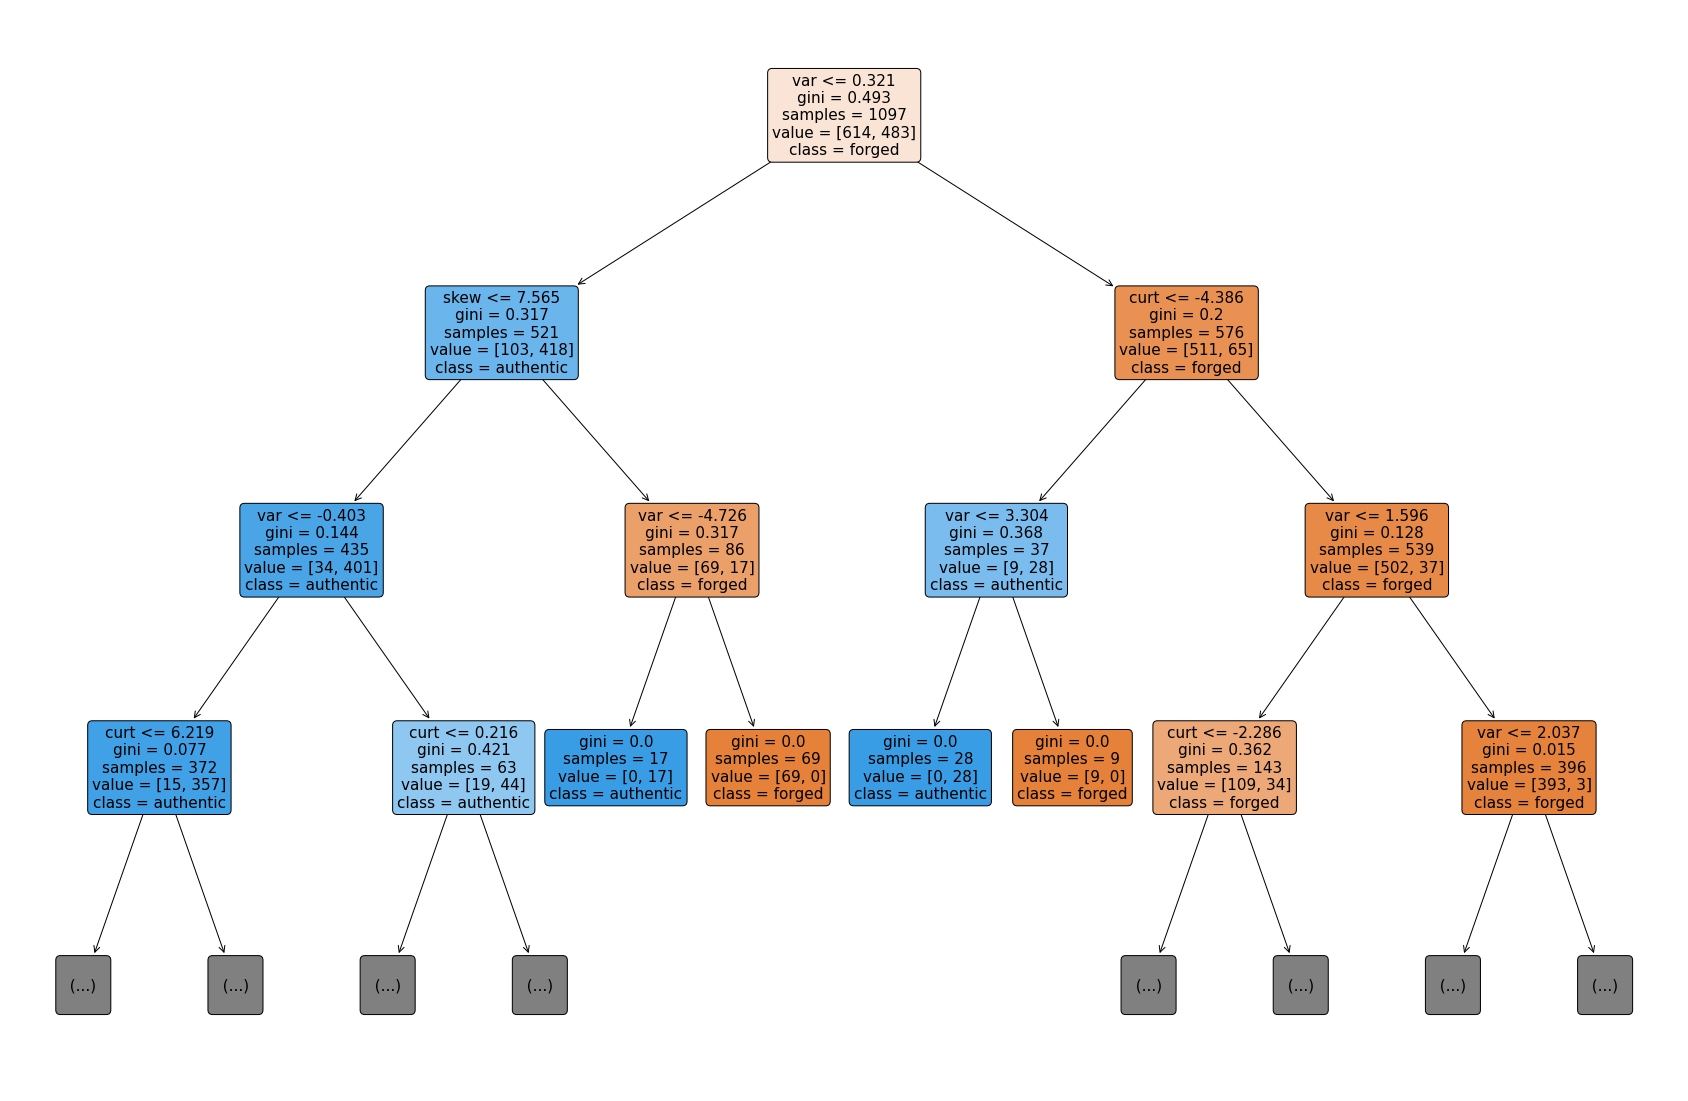

In [235]:
plotTree(model)

DecisionTreeClassifier is a class in sklearn capable of performing multi-class classification on a dataset.
As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, of shape (samples, features) holding the training samples, and an array Y of integer values, shape (samples), holding the class labels for the training samples,after being fitted the model can then be used to predict the class of samples.

Decision trees can also be applied to regression problems, using the DecisionTreeRegressor class in sklearn.
As in the classification setting, the fit method will take as argument arrays X and y, only that in this case y is expected to have floating point values instead of integer values.

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [229]:
col_names = ['variance', 'skewness', 'curtosis', 'entropy', 'authentic']
data = pd.read_csv("bankAuth.txt", names=col_names)
print(data.describe())
print(data.info())

          variance     skewness     curtosis      entropy    authentic
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   variance   1372 non-null   float64
 1   skewness   1372 non-null   float64
 2   curtosis   1372 non-null   float64
 3   entropy    1372 non-null   float64
 4   authentic 

In [230]:
# your code here
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.2,random_state=41)

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [231]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate

model = DecisionTreeClassifier(max_depth=3,criterion='entropy')
model.fit(X_train, Y_train)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_pred,Y_test)
tmp=model.score(X_train,Y_train)

lst1=[]
lst1.append("Entropy")
lst2=[]
lst2.append(accuracy)
lst3=[]
lst3.append(tmp)


data1={
    "Alpha" : lst1,
    "RMSE on train" : tmp,
    "RMSE on test" : lst2
}

df=pd.DataFrame(data1)

model = DecisionTreeClassifier(max_depth=3,criterion='gini')
model.fit(X_train, Y_train)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_pred,Y_test)
tmp=model.score(X_train,Y_train)

lst1.append("Gini")

lst2.append(accuracy)
lst3.append(tmp)

data2={
    "Alpha" : lst1,
    "RMSE on train data" : tmp,
    "RMSE on test data" : lst2
}

df=pd.DataFrame(data2)

print(tabulate(df,headers='keys',tablefmt='psql'))

+----+---------+----------------------+---------------------+
|    | Alpha   |   RMSE on train data |   RMSE on test data |
|----+---------+----------------------+---------------------|
|  0 | Entropy |             0.935278 |            0.952727 |
|  1 | Gini    |             0.935278 |            0.952727 |
+----+---------+----------------------+---------------------+


In [232]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate

max_depth_lst=[]
accuracy_lst=[]
accuracy_lst1=[]

for max_depth in range(1,51,1):
  model = DecisionTreeClassifier(max_depth=max_depth)
  model.fit(X_train, Y_train)
  y_pred=model.predict(X_test)
  accuracy=accuracy_score(y_pred,Y_test)
  max_depth_lst.append(max_depth)
  tmp=model.score(X_train,Y_train)
  accuracy_lst.append(accuracy)
  accuracy_lst1.append(tmp)

data2={
    "Max_depth" : max_depth_lst,
    "Accuracy on train data" : accuracy_lst1,
    "Accuracy on test data" : accuracy_lst
}


df=pd.DataFrame(data2)

print(tabulate(df,headers='keys',tablefmt='psql'))

+----+-------------+--------------------------+-------------------------+
|    |   Max_depth |   Accuracy on train data |   Accuracy on test data |
|----+-------------+--------------------------+-------------------------|
|  0 |           1 |                 0.846855 |                0.88     |
|  1 |           2 |                 0.911577 |                0.938182 |
|  2 |           3 |                 0.935278 |                0.952727 |
|  3 |           4 |                 0.958979 |                0.96     |
|  4 |           5 |                 0.985415 |                0.952727 |
|  5 |           6 |                 0.998177 |                0.978182 |
|  6 |           7 |                 1        |                0.981818 |
|  7 |           8 |                 1        |                0.981818 |
|  8 |           9 |                 1        |                0.981818 |
|  9 |          10 |                 1        |                0.981818 |
| 10 |          11 |                 1

In [233]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate

min_samples_split_lst=[]
accuracy_lst=[]
accuracy_lst1=[]

for min_samples_split in range(2,51,1):
  model = DecisionTreeClassifier(min_samples_split=min_samples_split)
  model.fit(X_train, Y_train)
  y_pred=model.predict(X_test)
  accuracy=accuracy_score(y_pred,Y_test)
  min_samples_split_lst.append(min_samples_split)
  tmp=model.score(X_train,Y_train)
  accuracy_lst.append(accuracy)
  accuracy_lst1.append(tmp)

data2={
    "min_samples_split" : min_samples_split_lst,
    "Accuracy on train data" : accuracy_lst1,
    "Accuracy on test data" : accuracy_lst
}


df=pd.DataFrame(data2)

print(tabulate(df,headers='keys',tablefmt='psql'))

+----+---------------------+--------------------------+-------------------------+
|    |   min_samples_split |   Accuracy on train data |   Accuracy on test data |
|----+---------------------+--------------------------+-------------------------|
|  0 |                   2 |                 1        |                0.981818 |
|  1 |                   3 |                 0.999088 |                0.981818 |
|  2 |                   4 |                 0.999088 |                0.981818 |
|  3 |                   5 |                 0.998177 |                0.981818 |
|  4 |                   6 |                 0.998177 |                0.981818 |
|  5 |                   7 |                 0.998177 |                0.981818 |
|  6 |                   8 |                 0.998177 |                0.981818 |
|  7 |                   9 |                 0.998177 |                0.981818 |
|  8 |                  10 |                 0.997265 |                0.978182 |
|  9 |          

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

In [234]:
# your code here
min_split = [3,5,7]
depth = [3,5,7]
criteria = ["entropy","gini"]
min_split_lst = []
accuraccy_lst1 = []
accuraccy_lst2 = []
for i in criteria:
  for j in depth:
    for k in min_split:
      model = DecisionTreeClassifier(min_samples_split=k,max_depth=j,criterion=i)
      model = model.fit(X_train,Y_train)
      Y_pred=model.predict(X_test)
      min_split_lst.append(i)
      X_pred=model.predict(X_train)
      accuraccy_lst1.append(accuracy_score(Y_pred,Y_test))
      accuraccy_lst2.append(accuracy_score(X_pred,Y_train))
data = {
  "min_samples_split": min_split_lst,
  "accuracy on train data":accuraccy_lst2,
  "accuracy on test data": accuraccy_lst1
}
dff = pd.DataFrame(data)
print(tabulate(dff, headers='keys', tablefmt='psql'))

+----+---------------------+--------------------------+-------------------------+
|    | min_samples_split   |   accuracy on train data |   accuracy on test data |
|----+---------------------+--------------------------+-------------------------|
|  0 | entropy             |                 0.954421 |                0.952727 |
|  1 | entropy             |                 0.954421 |                0.952727 |
|  2 | entropy             |                 0.954421 |                0.952727 |
|  3 | entropy             |                 0.987238 |                0.956364 |
|  4 | entropy             |                 0.987238 |                0.956364 |
|  5 | entropy             |                 0.987238 |                0.956364 |
|  6 | entropy             |                 1        |                0.985455 |
|  7 | entropy             |                 1        |                0.985455 |
|  8 | entropy             |                 1        |                0.985455 |
|  9 | gini     